# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split

In [2]:
data_init = pd.read_csv('data/google_stock.csv', parse_dates = [0])

In [3]:
data_init.info(); print()
print("Shape:", data_init.shape); print()
print(data_init.head(5)); print()
data_init.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB

Shape: (1260, 7)

        Date        Open        High         Low       Close   Adj Close  \
0 2016-03-28  736.789978  738.989990  732.500000  733.530029  733.530029   
1 2016-03-29  734.590027  747.250000  728.760010  744.770020  744.770020   
2 2016-03-30  750.099976  757.880005  748.739990  750.530029  750.530029   
3 2016-03-31  749.250000  750.849976  740.940002  744.950012  744.950012   
4 

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1147.178547,1158.696803,1136.546811,1148.050058,1148.050058,1.628621e+06
std,315.399648,320.708354,311.384816,316.044823,316.044823,7.128469e+05
min,671.000000,672.299988,663.283997,668.260010,668.260010,3.468000e+05
25%,928.647476,932.752518,922.000000,928.510025,928.510025,1.199200e+06
50%,1109.075012,1122.565002,1098.335022,1109.859985,1109.859985,1.450000e+06
75%,1278.017487,1294.860046,1271.057495,1289.940033,1289.940033,1.832425e+06
max,2119.270020,2152.679932,2104.360107,2128.310059,2128.310059,6.207000e+06


In [4]:
data_init['Date'] = data_init['Date'].dt.strftime('%Y-%U')
data_init

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-13,736.789978,738.989990,732.500000,733.530029,733.530029,1301300
1,2016-13,734.590027,747.250000,728.760010,744.770020,744.770020,1903800
2,2016-13,750.099976,757.880005,748.739990,750.530029,750.530029,1782400
3,2016-13,749.250000,750.849976,740.940002,744.950012,744.950012,1718800
4,2016-13,738.599976,750.340027,737.000000,749.909973,749.909973,1576700
...,...,...,...,...,...,...,...
1255,2021-12,2041.839966,2057.989990,2026.069946,2038.589966,2038.589966,1954800
1256,2021-12,2051.699951,2072.302002,2039.219971,2052.959961,2052.959961,1367000
1257,2021-12,2065.370117,2078.209961,2041.555054,2045.060059,2045.060059,1154000
1258,2021-12,2044.810059,2058.870117,2010.729980,2044.359985,2044.359985,1418900


In [5]:
data = pd.DataFrame(data_init.groupby('Date').High.mean())
data

,High
Date,
2016-13,749.062000
2016-14,746.857996
2016-15,752.304004
2016-16,758.530408
2016-17,714.093188
...,...
2021-08,2088.019971
2021-09,2097.351660
2021-10,2099.562012


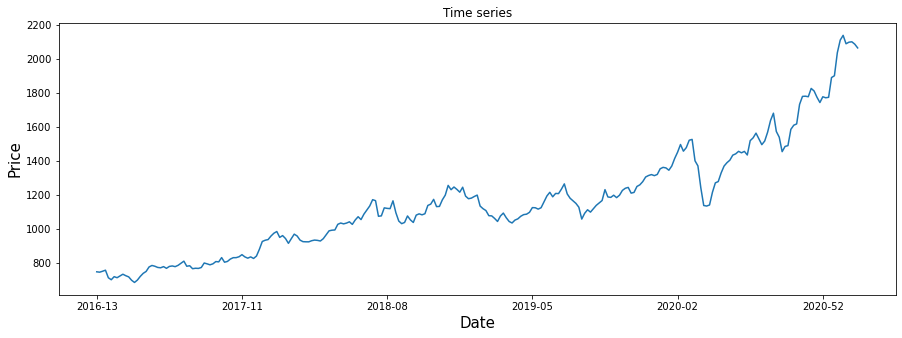

In [6]:
plt.figure(figsize=(15, 5))
plt.title('Time series')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=90, fontsize=15)
data['High'].plot();

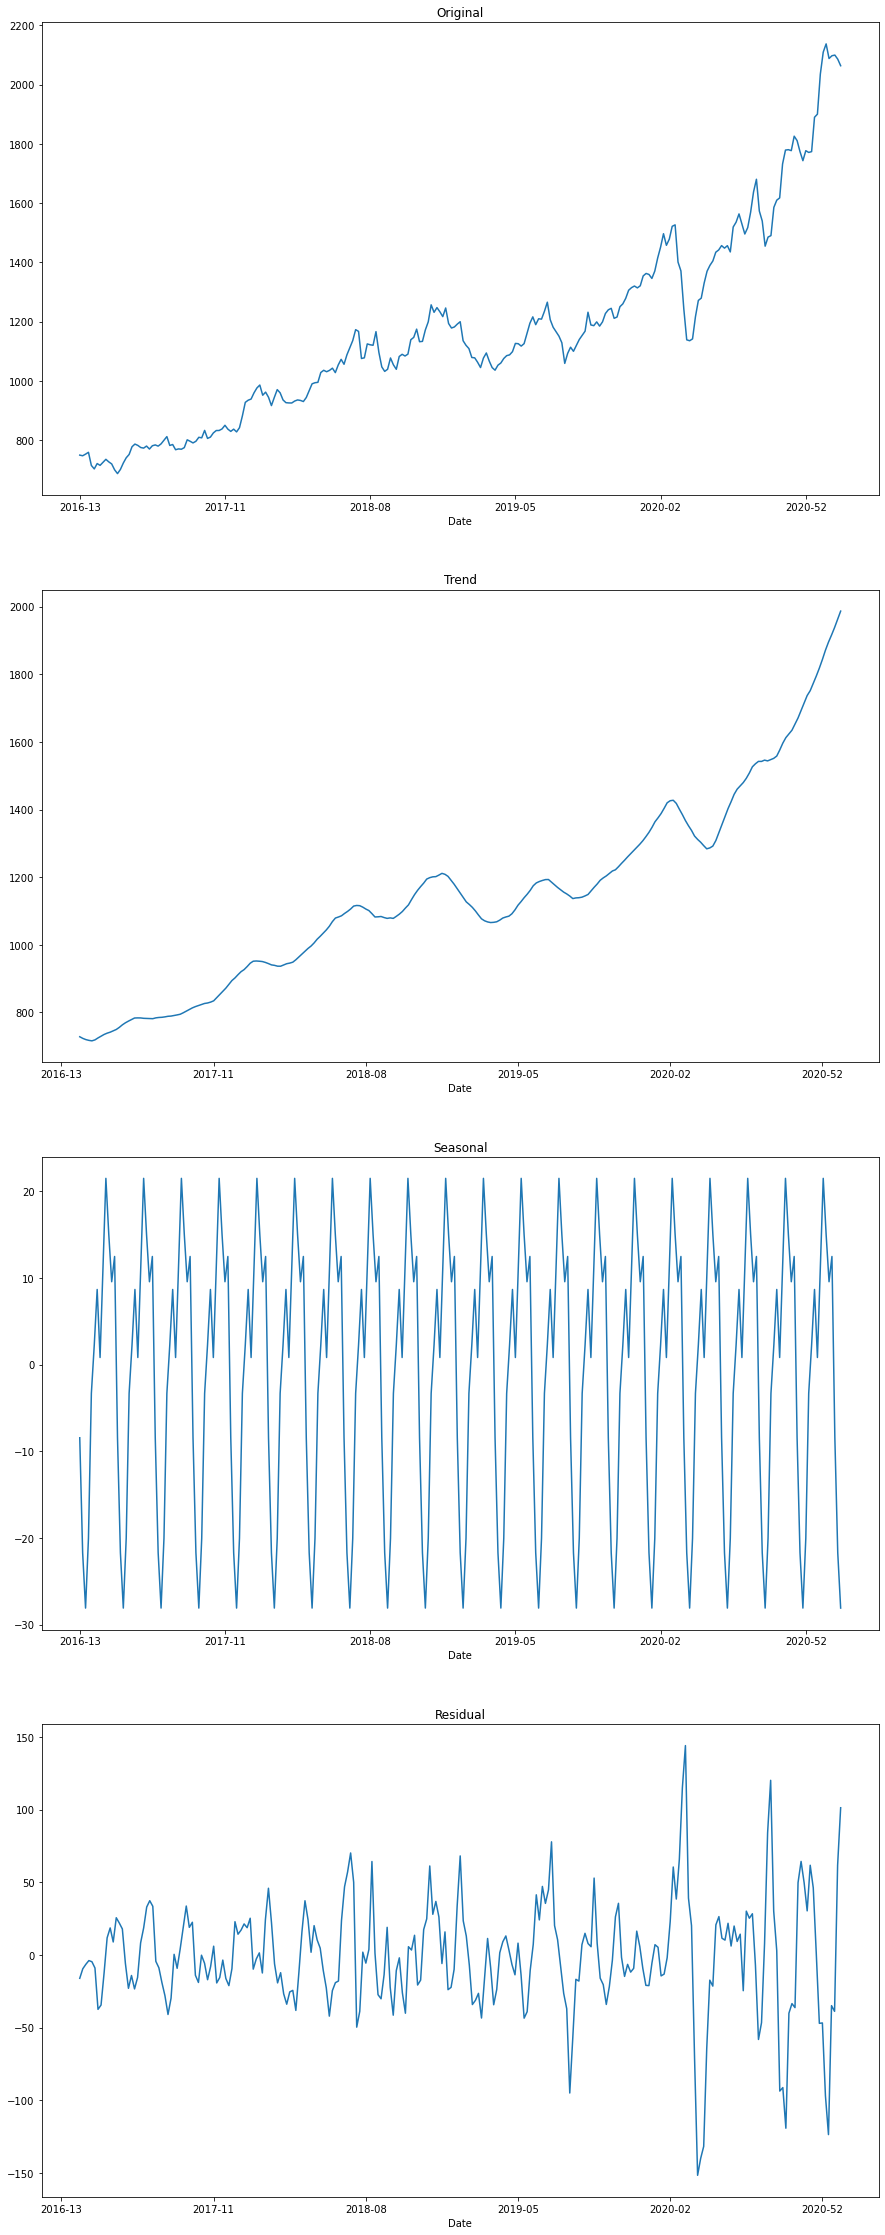

In [7]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (15, 40))
decompose = seasonal_decompose(data[['High']], period = 13)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax = ax[0])
decompose.trend.plot(ax = ax[1])
decompose.seasonal.plot(ax = ax[2])
decompose.resid.plot(ax = ax[3]);

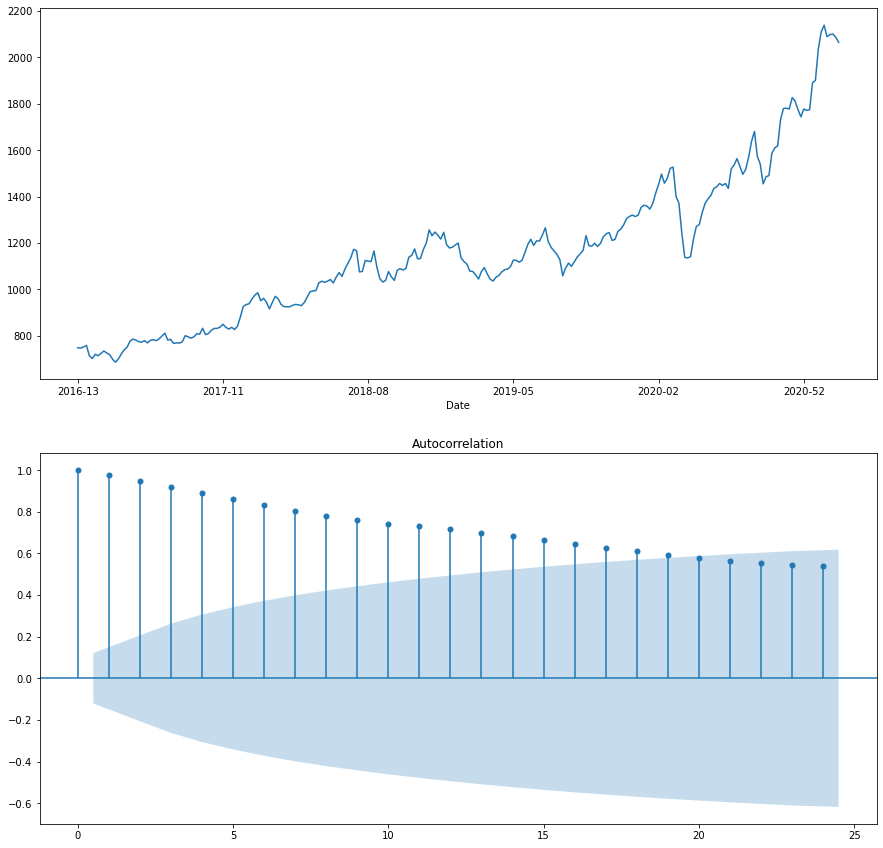

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))
data['High'].plot(ax = ax[0])
plot_acf(data['High'], lags = 24, ax = ax[1]);

In [9]:
p_value = adfuller(data['High'])[1]
print(p_value)
print("p_value > 0.05? ", p_value > 0.05)

0.9821717491335329
p_value > 0.05?  True


In [10]:
data['High_log'] = np.log(data['High'])
data.head(5)

,High,High_log
Date,,
2016-13,749.062000,6.618822
2016-14,746.857996,6.615875
2016-15,752.304004,6.623141
2016-16,758.530408,6.631383
2016-17,714.093188,6.571013


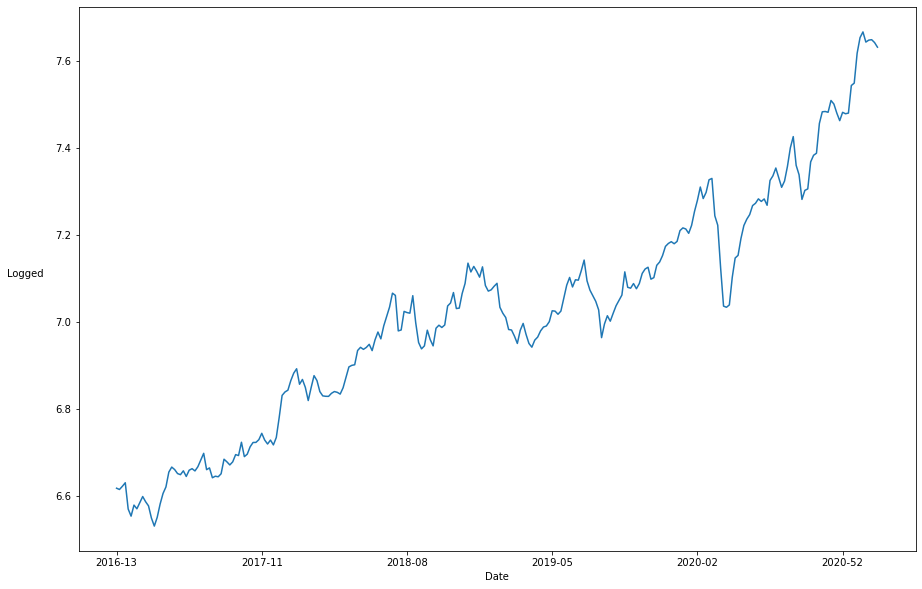

In [11]:
plt.figure(figsize=(15, 10))
plt.ylabel('Logged', rotation=0, labelpad=30)
data['High_log'].plot();

In [12]:
data['High_diff'] = data['High'] - data['High'].shift(1)
data.head(5)

,High,High_log,High_diff
Date,,,
2016-13,749.062000,6.618822,NaN
2016-14,746.857996,6.615875,-2.204004
2016-15,752.304004,6.623141,5.446008
2016-16,758.530408,6.631383,6.226404
2016-17,714.093188,6.571013,-44.437219


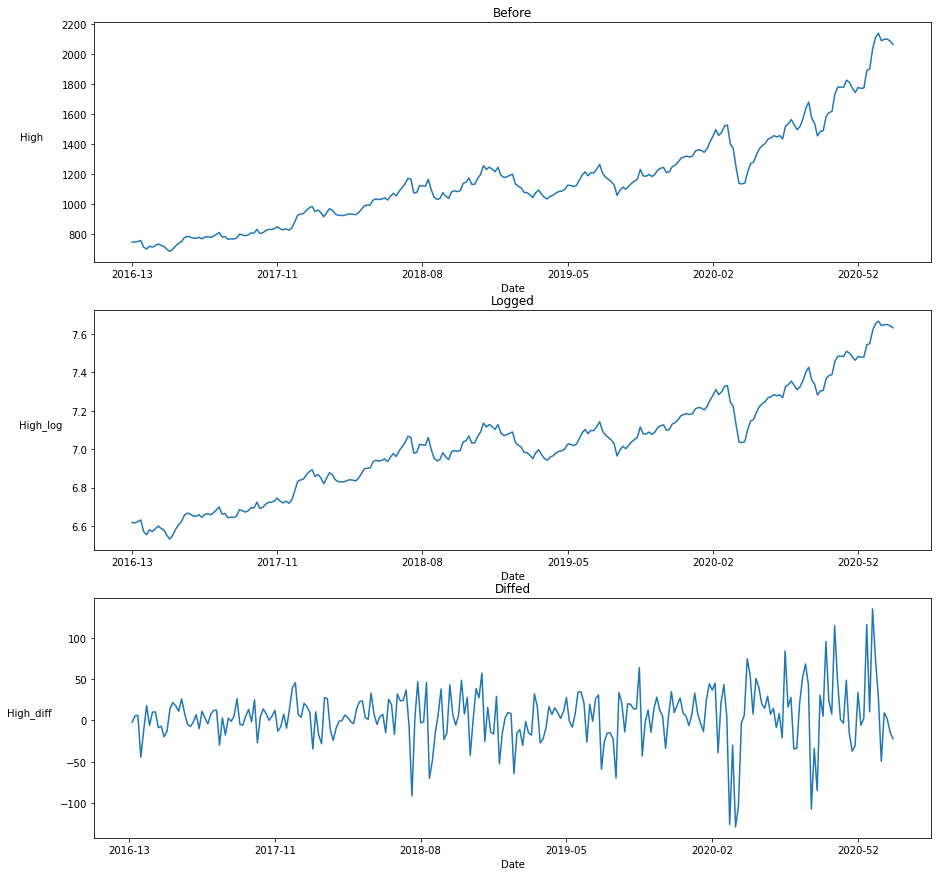

In [13]:
plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15))

ax = plt.subplot(311)
ax.set_title('Before')
ax.set_ylabel('High', rotation = 0, labelpad = 30)
data['High'].plot(ax = ax);

ax = plt.subplot(312)
ax.set_title('Logged')
ax.set_ylabel('High_log', rotation = 0, labelpad = 30)
data['High_log'].plot(ax = ax);

ax = plt.subplot(313)
ax.set_title('Diffed')
ax.set_ylabel('High_diff', rotation = 0, labelpad = 30)
data['High_diff'].plot(ax = ax);

In [14]:
shifts = 1

In [15]:
data['High_log_diff'] = data['High_log'] - data['High_log'].shift(shifts)
data

,High,High_log,High_diff,High_log_diff
Date,,,,
2016-13,749.062000,6.618822,NaN,NaN
2016-14,746.857996,6.615875,-2.204004,-0.002947
2016-15,752.304004,6.623141,5.446008,0.007265
2016-16,758.530408,6.631383,6.226404,0.008242
2016-17,714.093188,6.571013,-44.437219,-0.060369
...,...,...,...,...
2021-08,2088.019971,7.643972,-49.381274,-0.023374
2021-09,2097.351660,7.648431,9.331689,0.004459
2021-10,2099.562012,7.649484,2.210352,0.001053


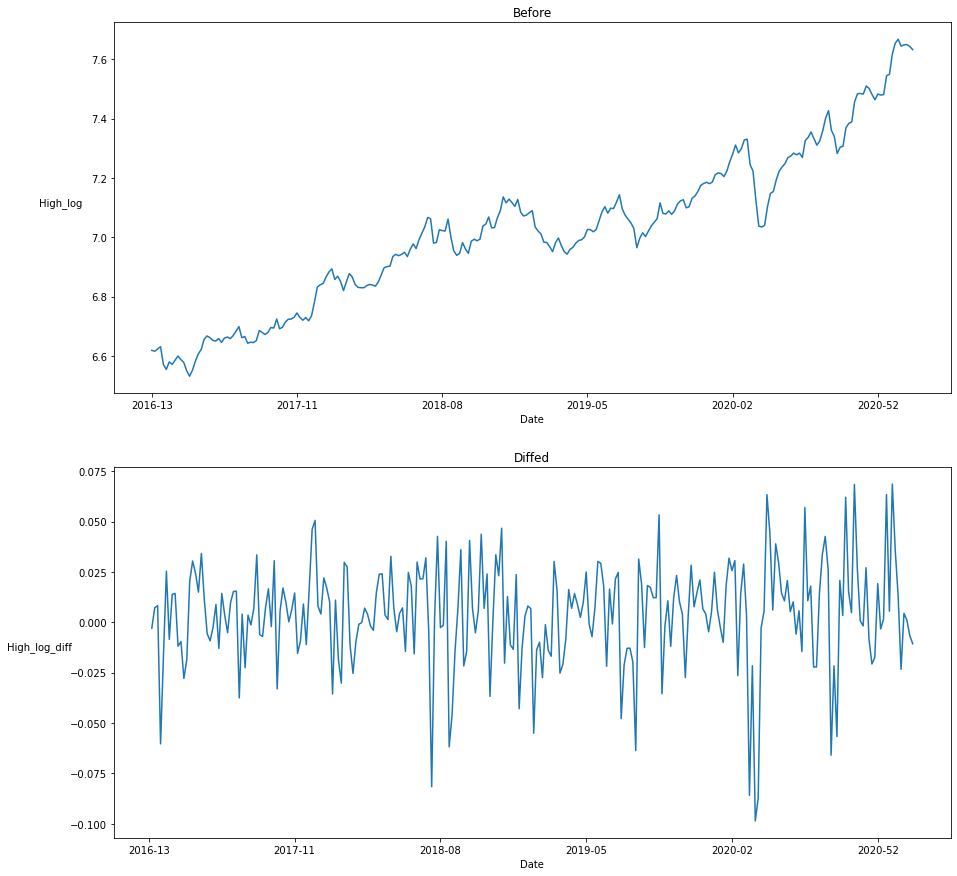

In [16]:
plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))

ax = plt.subplot(211)
ax.set_title('Before')
ax.set_ylabel('High_log', rotation = 0, labelpad = 30)
data['High_log'].plot(ax = ax);

ax = plt.subplot(212)
ax.set_title('Diffed')
ax.set_ylabel('High_log_diff', rotation = 0, labelpad = 30)
data['High_log_diff'].plot(ax = ax);

p for log =  0.9354611402260989
p for diff =  8.802502918426818e-24
p for diffed log =  2.2325980582571804e-24


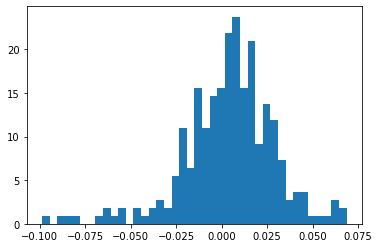

In [17]:
p_log_value = adfuller(data['High_log'])[1]
p_diff_value = adfuller(data['High_diff'][1:])[1]
p_log_diff_value = adfuller(data['High_log_diff'][shifts:])[1]

print("p for log = ", p_log_value)
print("p for diff = ", p_diff_value)
print("p for diffed log = ", p_log_diff_value)

plt.hist(data['High_log_diff'], density = True, bins = 40);

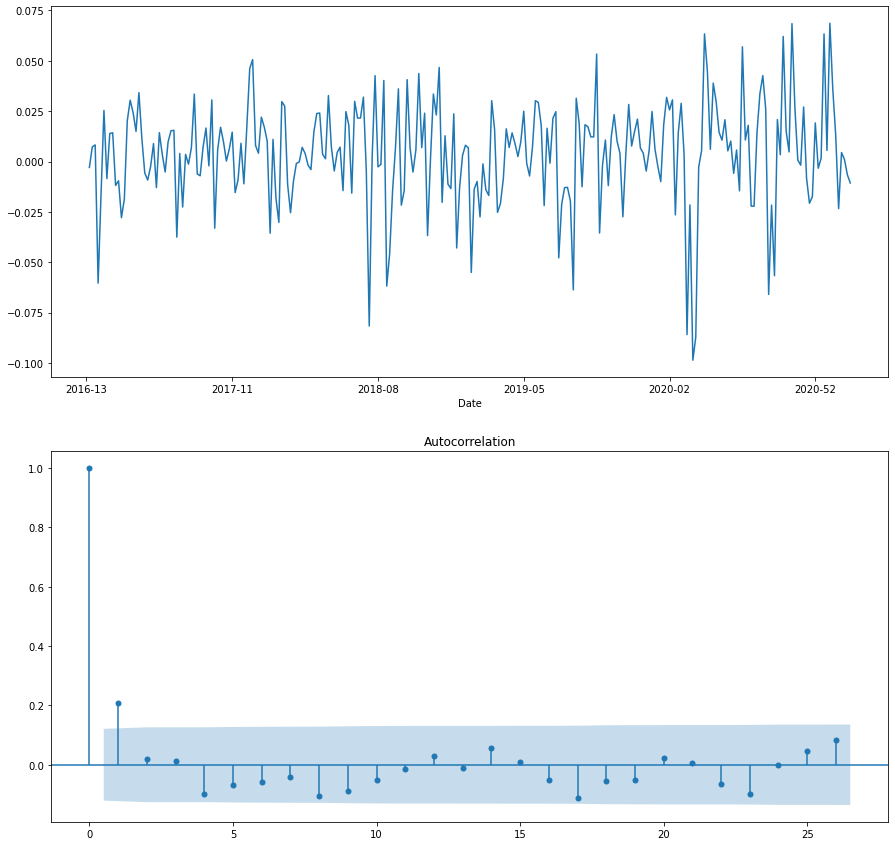

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))
data['High_log_diff'].plot(ax = ax[0])
plot_acf(data['High_log_diff'][shifts:], lags = 26, ax = ax[1]);

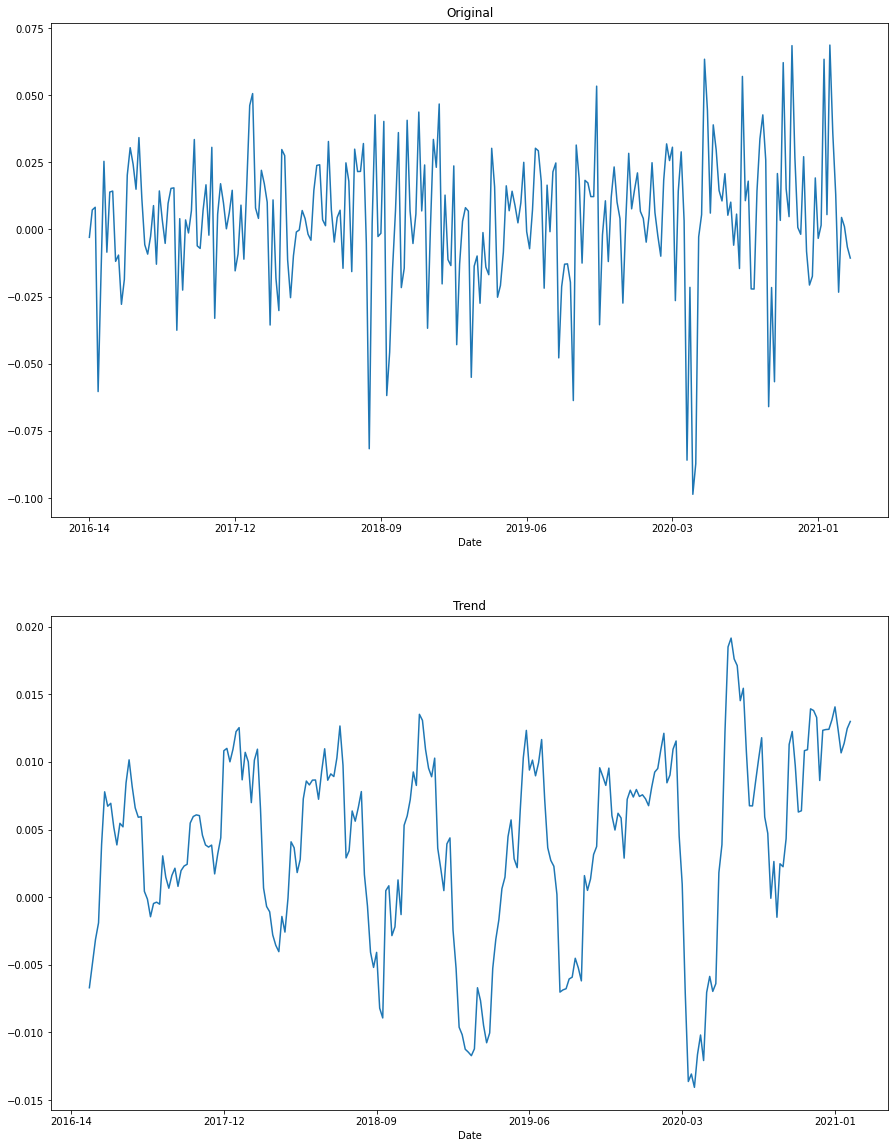

In [55]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 20))
decompose = seasonal_decompose(data['High_log_diff'][shifts:], period = 13)

ax[0].set_title('Original')
ax[1].set_title('Trend')

decompose.observed.plot(ax = ax[0])
decompose.trend.plot(ax = ax[1]);

In [20]:
d=1
D=1

qs = range(1, 4) # 1
Qs = range(1, 3) # 1

ps = range(1, 4) # 1
Ps = range(1, 4) # 1

train_size = 210
test_size = 53

In [21]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [22]:
train = data[:-test_size]

In [23]:
%%time
import statsmodels.api as sm

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            train['High_log'], 
            order = (param[0], d, param[1]), 
            seasonal_order = (param[2], D, param[3], 13)
        ).fit(disp = -1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
  2%|█▌                                                                                 | 1/54 [00:02<02:22,  2.70s/it]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmod

Wall time: 7min 52s


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())
print(best_model.summary())

      parameters         aic
0   (1, 1, 1, 1) -868.405679
2   (1, 1, 2, 1) -867.457365
3   (1, 1, 2, 2) -867.101765
6   (1, 2, 1, 1) -866.417230
18  (2, 1, 1, 1) -866.067035
                                     SARIMAX Results                                      
Dep. Variable:                           High_log   No. Observations:                  210
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 13)   Log Likelihood                 439.203
Date:                            Wed, 24 Nov 2021   AIC                           -868.406
Time:                                    16:48:13   BIC                           -852.015
Sample:                                         0   HQIC                          -861.770
                                            - 210                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

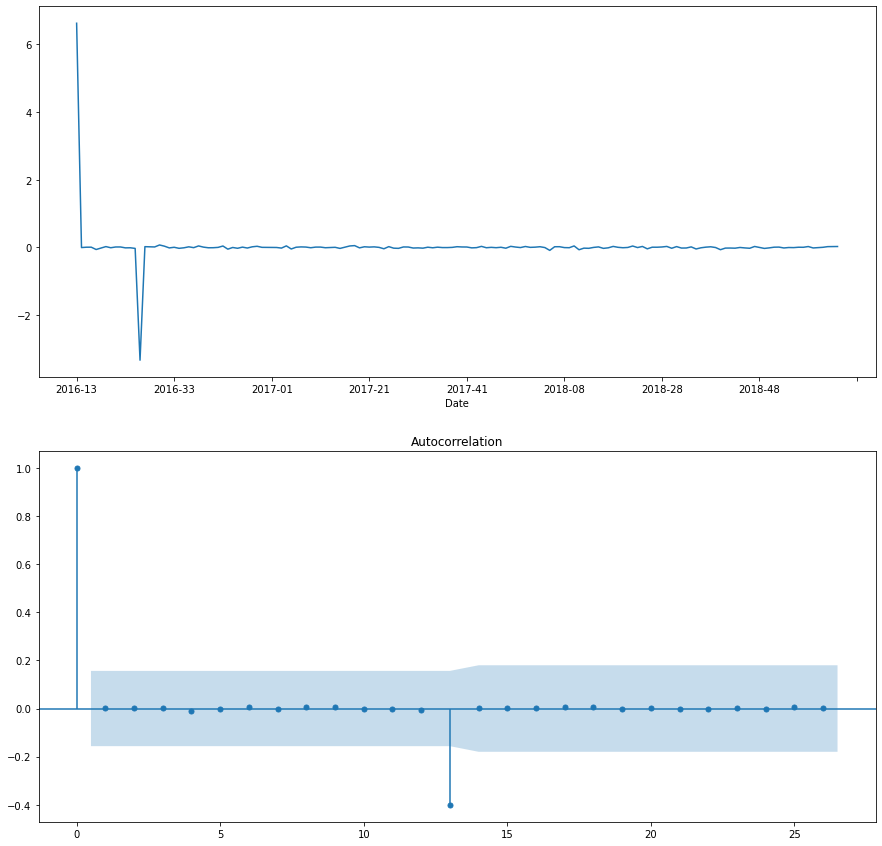

In [39]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[:-test_size].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[:-test_size].values.squeeze(), lags=26, ax=ax);

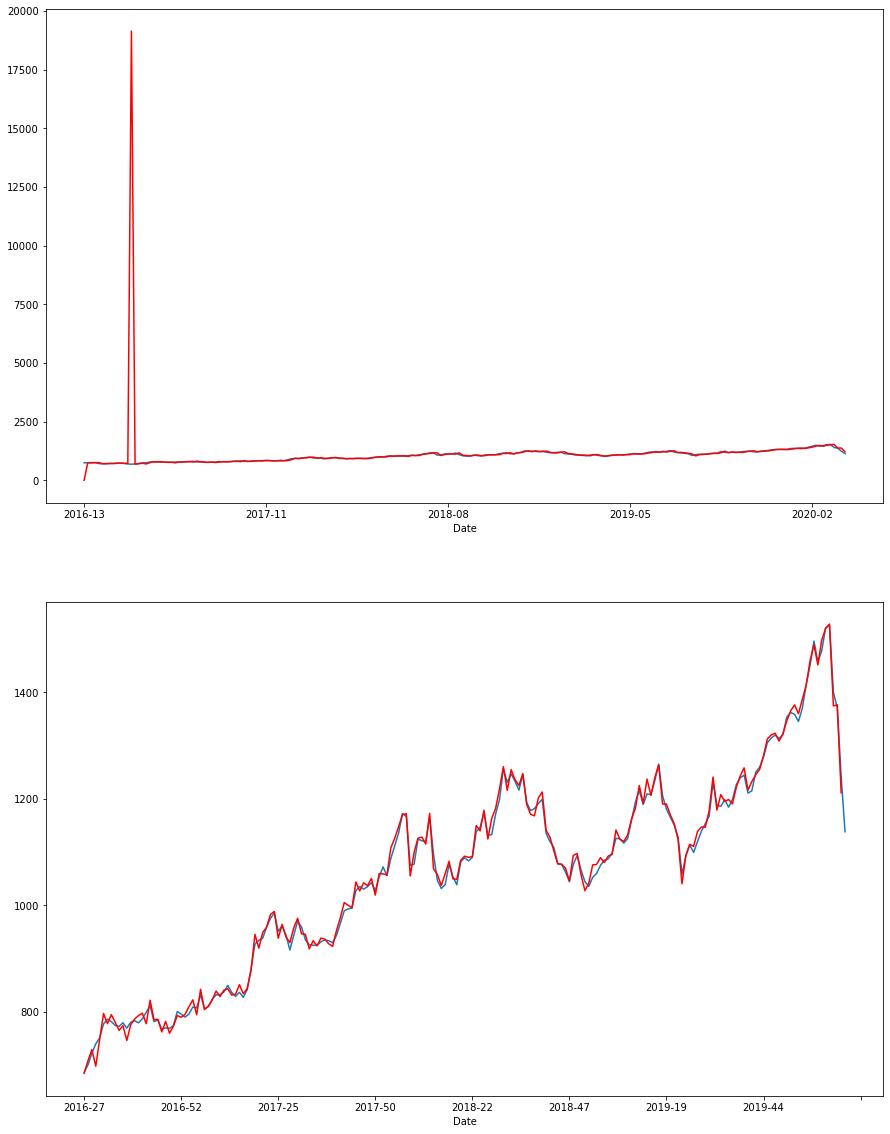

In [40]:
data['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15, 20))

plt.subplot(211)
data['High'][:-test_size].plot()
data['Model'][:-test_size].plot(c = 'r');

plt.subplot(212)
data['High'][13:-test_size].plot()
data['Model'][14:-test_size].plot(c = 'r');

In [41]:
print(data.shape)
print(data.head(5))
print(data.tail(5))

(263, 5)
               High  High_log  High_diff  High_log_diff       Model
Date                                                               
2016-13  749.062000  6.618822        NaN            NaN    1.000000
2016-14  746.857996  6.615875  -2.204004      -0.002947  749.062000
2016-15  752.304004  6.623141   5.446008       0.007265  746.857995
2016-16  758.530408  6.631383   6.226404       0.008242  752.304004
2016-17  714.093188  6.571013 -44.437219      -0.060369  758.530408
                High  High_log  High_diff  High_log_diff  Model
Date                                                           
2021-08  2088.019971  7.643972 -49.381274      -0.023374    NaN
2021-09  2097.351660  7.648431   9.331689       0.004459    NaN
2021-10  2099.562012  7.649484   2.210352       0.001053    NaN
2021-11  2085.800049  7.642908 -13.761963      -0.006576    NaN
2021-12  2063.672412  7.632242 -22.127637      -0.010665    NaN


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:xlabel='Date'>

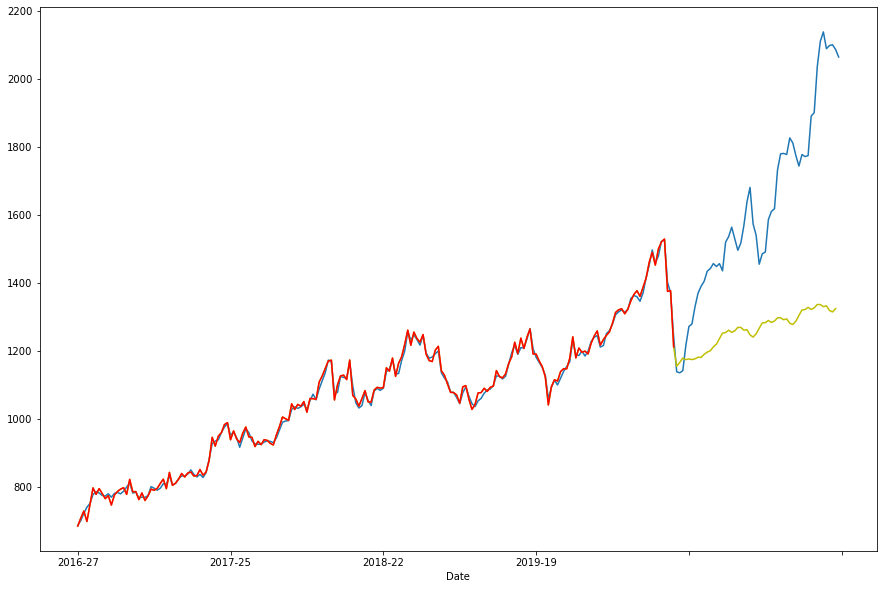

In [51]:
plt.figure(figsize=(15,10))
data['High'][13:].plot()
data['Model'][train_size:]= np.exp(best_model.predict(start = train_size, end = train_size + test_size - 1))
   
data['Model'][14:].plot(c = 'y')
data['Model'][14:train_size].plot(c = 'r') 

In [52]:
def SMAPE(actual, forecasted):
    delim = np.abs(forecasted - actual).sum()
    denom = (forecasted + actual).sum()
    return delim / denom * 100
    
SMAPE(data['High'][train_size:], data['Model'][train_size:])

12.98812539696193

In [53]:
print(metrics.mean_absolute_percentage_error(data['High'][train_size:], data['Model'][train_size:]) * 100)

21.55271763987957
